# Compute statistics about the global database

* use list_profiles, list_tags, list_deployments
* list files are created in sc_list_profiles.ipynb

In [2]:
from pathlib import Path
import sys
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import gsw
from IPython.display import display,Image

import importlib
import meop
importlib.reload(meop)
processdir = meop.processdir

import meop_plot_data
importlib.reload(meop_plot_data)

pass

## Write statistics

In [9]:
list_profiles, list_tags, list_deployments = meop.read_list_profiles(rebuild=False,verbose=False,public=False,Tdata=True)
list_profiles_public, list_tags_public, list_deployments_public = meop.read_list_profiles(rebuild=False,verbose=False,public=True,Tdata=True)

In [10]:
print('Number of valid T profiles, total :',list_profiles.N_TEMP.count())
print('Number of valid T profiles, public:',list_profiles_public.N_TEMP.count())
print('Number of valid T profiles, public, south of 55S: ',list_profiles_public[list_profiles_public.LATITUDE<-55].N_TEMP.count())

Number of valid T profiles, total : 657625
Number of valid T profiles, public: 590537
Number of valid T profiles, public, south of 55S:  272609


In [11]:
print('Number of valid S profiles, total :',list_profiles.N_PSAL.count())
print('Number of valid S profiles, public:',list_profiles_public.N_PSAL.count())
print('Number of valid S profiles, public, south of 55S: ',list_profiles_public[list_profiles_public.LATITUDE<-55].N_PSAL.count())

Number of valid S profiles, total : 521754
Number of valid S profiles, public: 457743
Number of valid S profiles, public, south of 55S:  234952


In [17]:
# select tags with at least one profile south of 55S
index_tags = list_profiles_public[list_profiles_public.LATITUDE<-55].SMRU_PLATFORM_CODE.unique()
print('Number of valid tags, public, south of 55S: ',len(index_tags))

Number of valid tags, public, south of 55S:  781


In [9]:
# select tags with at least one Chla profile
index_tags = list_profiles_public[list_profiles_public.N_CHLA>0].SMRU_PLATFORM_CODE.unique()
print('Number of valid tags, public, with chla: ',len(index_tags))

# select tags with at least one Chla profile south of 50S
index_tags = list_profiles_public[(list_profiles_public.N_CHLA>0)&(list_profiles_public.LATITUDE<-55)].SMRU_PLATFORM_CODE.unique()
print('Number of valid tags, public, with chla: ',len(index_tags))

# Number of profiles of Chla
print('')
print('Number of valid F profiles, total : ',list_profiles[list_profiles.N_CHLA>0].N_CHLA.count())
print('Number of valid F profiles, public: ',list_profiles_public[list_profiles_public.N_CHLA>0].N_CHLA.count())
print('Number of valid F profiles, public, south of 55S: ',list_profiles_public[(list_profiles_public.N_CHLA>0)&(list_profiles_public.LATITUDE<-55)].N_CHLA.count())

Number of valid tags, public, with chla:  108
Number of valid tags, public, with chla:  26

Number of valid F profiles, total :  26801
Number of valid F profiles, public:  26328
Number of valid F profiles, public, south of 55S:  3528


## Create plots in public folder

Using matplotlib backend: agg
AUSTRALIA
wd04-896-11
wd04-880-11
wd04-900-11
wd04-883-11
wd04-908-11
wd04-897-11
wd04-899-11
wd04-881-11
wd04-838-11
wd04-884-11
wd04-909-11
wd04-906-11
wd04-910-11
wd04-907-11
wd04-898-11
wd04-911-11
wd04-836-11
awru1-B-06
awru1-C-06
awru1-A-06
ct149-928-18
ct149-924-18
ct149-930-18
ct149-923-18
ct149-922-18
ct149-929-18
ct149-926-18
ct149-925-18
ct149-927-18
ct2-9920-04
ct2-9919-04
ct2-9925-04
ct2-9916-04
ct36-E-09
ct36-D-09
ct36-R1-09
ct36-A-09
ct36-R4-09
ct36-C-09
ct36-B-09
ct36-F-09
ct38w-Elodie-08
ct38w-QueenEliz-08
ct38w-Denise-08
ct38w-Mathilde-08
ct47-I-09
ct47-G-09
ct47-C-09
ct47-E-09
ct47-F-09
ct47-A-09
ct47-B-09
ct47-D-09
ct6-10006-05
ct6-10018-05
ct6-9920-05


KeyboardInterrupt: 

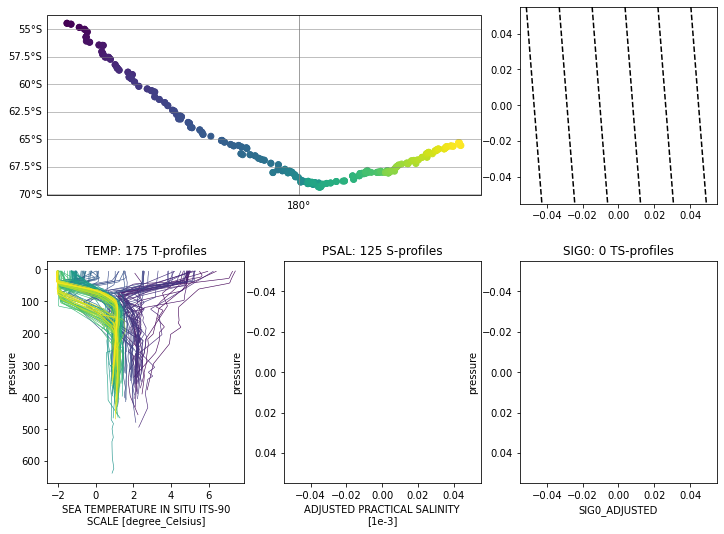

In [104]:
publish_data = False
if publish_data:
    
    %matplotlib auto

    config = 'jupyter_froqu_pc207_linux'
    folder_public = pd.read_json(meop.processdir / 'configs.json').configs[config]['public']
    
    list_tags = pd.read_csv(config.version.CTDnew+'_list_tags.csv',index_col=['SMRU_PLATFORM_CODE'])
    list_tags_public = list_tags[list_tags.PUBLIC==1]
    for COUNTRY in list_tags_public.COUNTRY.unique():
        print(COUNTRY)
        folder_plots = folder_public / COUNTRY / 'PLOTS'
        folder_plots.mkdir(parents=True, exist_ok=True)
        list_tags_country = list_tags_public.loc[list_tags_public.COUNTRY==COUNTRY,['SMRU_PLATFORM_CODE']]
        for tag in list_tags_country.values[:,0]:
            print(tag)
            if meop.fname_prof(tag,qf='hr2').is_file():
                with meop.read_ncfile(tag,qf='hr2') as ds:
                    ds = ds.assign_coords(pressure=("N_LEVELS", ds.PRES[0,:]))
                    ds['SIG0_ADJUSTED'] = (('N_PROF','N_LEVELS'),gsw.sigma0(ds.PSAL_ADJUSTED,ds.TEMP_ADJUSTED))
                    depl = meop.EXP_from_SMRU_CODE(tag)
                    namefig = folder_plots / (tag+'_data_description.png')
                    if not namefig.exists():
                        meop.plot_data_tags(ds,namefig=namefig)
                        plt.close()